x_initial:  [0.         0.16304822 0.32609645 0.48914467 0.55941319 0.64688405
 0.75873009 0.90668885 1.11176954 1.11176954 1.11176954 1.11176954
 1.11176954 1.11176954 1.11176954 1.11176954 1.11176954 1.11176954
 1.11176954 1.11176954 1.11176954 1.11176954 1.11176954 1.11176954
 1.11176954 1.11176954 1.11176954 1.11176954 1.11176954]
iniciando simulação
len xref 58
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      133
Number of nonzeros in inequality constraint Jacobian.:       21
Number of nonzeros in Lagran

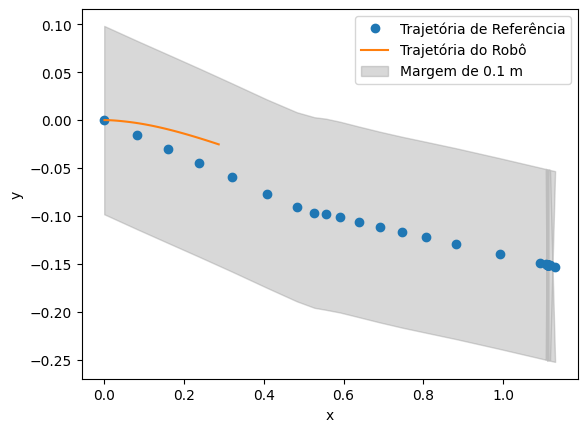

In [9]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff

class DifferentialDriveRobot:
    def __init__(self, R, L):
        self.R = R  # Raio da roda
        self.L = L  # Distância entre as rodas
        
        # Estados iniciais
        self.x = 0
        self.y = 0
        self.theta = 0

    def update(self, v_R, v_L, dt):
        v = (self.R / 2) * (v_R + v_L)
        omega = (self.R / self.L) * (v_R - v_L)
        
        self.x += v * np.cos(self.theta) * dt
        self.y += v * np.sin(self.theta) * dt
        self.theta += omega * dt

class MPCController:
    def __init__(self, robot, N, Q, R, dt, max_margin):
        self.robot = robot
        self.N = N  # Horizonte de predição
        self.Q = Q  # Penalização para erro de rastreamento
        self.R = R  # Penalização para esforço de controle
        self.dt = dt  # Intervalo de tempo
        self.max_margin = max_margin  # Distância máxima permitida da trajetória de referência


    def normalize_input(self, input_ref):
        x_initial = np.linspace(0, Xc[0], 4)
        y_initial = np.linspace(0, Yc[0], 4)

        
    def solve(self, x_ref, y_ref):
        model = pyo.ConcreteModel()

        model.N = self.N
        model.dt = self.dt
        model.Q = self.Q
        model.R = self.R
        model.x_ref = x_ref
        model.y_ref = y_ref

        # Variáveis de otimização
        model.v_R = pyo.Var(range(model.N), domain=pyo.Reals)
        model.v_L = pyo.Var(range(model.N), domain=pyo.Reals)

        # Estados
        model.x = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.y = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.theta = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)

        # Estados iniciais
        model.x[0].fix(self.robot.x)
        model.y[0].fix(self.robot.y)
        model.theta[0].fix(self.robot.theta)

        # Variável auxiliar para a Distância de Hausdorff
        model.hausdorff_dist = pyo.Var()

        # Função custo
        def objective_rule(model):
            cost = 0
            for t in range(model.N):
                cost += model.Q * ((model.x[t] - model.x_ref[t])**2 + (model.y[t] - model.y_ref[t])**2)
                cost += model.R * (model.v_R[t]**2 + model.v_L[t]**2)
            return cost
        
        model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Restrições de dinâmica
        model.dynamics = pyo.ConstraintList()
        for t in range(model.N):
            if (t > 4):
                v = (self.robot.R / 2) * (model.v_R[t-1] + model.v_L[t-1])

            v = (self.robot.R / 2) * (model.v_R[t] + model.v_L[t])
            omega = (self.robot.R / self.robot.L) * (model.v_R[t] - model.v_L[t])
            model.dynamics.add(model.x[t+1] == model.x[t] + v * pyo.cos(model.theta[t]) * model.dt)
            model.dynamics.add(model.y[t+1] == model.y[t] + v * pyo.sin(model.theta[t]) * model.dt)
            model.dynamics.add(model.theta[t+1] == model.theta[t] + omega * model.dt)

        # Limites das variáveis de controle
        def control_limits_rule_R(model, t):
            return (-1, model.v_R[t], 1)
        
        def control_limits_rule_L(model, t):
            return (-1, model.v_L[t], 1)

        model.control_limits_R = pyo.Constraint(range(model.N), rule=control_limits_rule_R)
        model.control_limits_L = pyo.Constraint(range(model.N), rule=control_limits_rule_L)

        def hausdorff_constraint(model):
            # Listas de pontos da trajetória atual e da referência
            traj_pred = [(model.x[i].value, model.y[i].value) for i in range(self.N)]
            traj_ref = [(model.x_ref[i], model.y_ref[i]) for i in range(self.N)]

            # Calcula a Distância de Hausdorff em ambas direções
            hd_dist_1 = directed_hausdorff(traj_pred, traj_ref)[0]
            hd_dist_2 = directed_hausdorff(traj_ref, traj_pred)[0]
            
            # Define a Distância de Hausdorff como o máximo entre as duas direções
            model.hausdorff_dist.set_value(max(hd_dist_1, hd_dist_2))

            # Restrições para garantir que a Distância de Hausdorff fique dentro do limite
            return model.hausdorff_dist <= self.max_margin

        # Adiciona a restrição de Hausdorff ao modelo
        model.hausdorff_constraint = pyo.Constraint(rule=hausdorff_constraint)


        # Solver
        solver = SolverFactory('ipopt')
        result = solver.solve(model, tee=True)

        # print('result', result)
        return model.v_R[0].value, model.v_L[0].value

# Parâmetros do robô
R = 0.1  # Raio da roda em metros
L = 0.5  # Distância entre as rodas em metros

# Criar instância do robô diferencial
robot = DifferentialDriveRobot(R, L)

# Criar instância do controlador MPC
# mpc = MPCController(robot, N=10, Q=120, R=0.015, dt=0.1)
predict_horizon = 10
margin = 0.1  # Distância da margem em metros

mpc = MPCController(robot, N=predict_horizon, Q=1, R=0, dt=12, max_margin=margin)

# Referência de trajetória
# x_ref = np.linspace(0, 10, 100)  # Aumentar o número de pontos de referência
# y_ref = np.sin(x_ref)
# y_ref = 0.05 * x_ref**2
# y_ref = np.sign(np.sin(2 * np.pi * 0.5 * x_ref))  # Frequência de 0.5 Hz
# y_ref = np.piecewise(x_ref, [x_ref < 5, x_ref >= 5], [0, 1])
Xc = [0.48914467381475923,
0.5594131906773301,
0.6468840483426161,
0.7587300914046574,
0.9066888477317598,
1.111769544992076]

Yc = [-0.09150369689456136,
-0.09846197449972373,
-0.10708867633569592,
-0.11807990084029595,
-0.13122400333321313,
-0.15099370681792523]

# y_ref = [0]*10 + [.057, .061, .064, .067, .063, .045, .028, .011, -.006, -.023] + [-.023] * 10
# x_ref = np.linspace(0,4.5,30)

# Cria uma trajetória suave do ponto (0, 0) até o primeiro ponto (Xc[0], Yc[0])
x_initial = np.linspace(0, Xc[0], 4)
y_initial = np.linspace(0, Yc[0], 4)

# x_initial = [0]
# y_initial = [0]
# Concatena a trajetória inicial com os pontos de referênci
x_initial = np.concatenate((x_initial[:-1], Xc, 20 * [Xc[-1]]))
y_initial = np.concatenate((y_initial[:-1], Yc, 20 * [Yc[-1]]))
print('x_initial: ', x_initial)
# x_ref = np.concatenate((x_ref, 20*[Xc[-1]]))
# y_ref = np.concatenate((y_ref, 20*[Yc[-1]]))

# Cria uma amostragem mais densa da trajetória usando interpolação
num_intermediate_points = 2  # Quantidade de pontos entre cada ponto de Xc e Yc
t_original = np.linspace(0, 1, len(x_initial))  # Tempo para os pontos originais
t_dense = np.linspace(0, 1, len(x_initial) * num_intermediate_points)  # Tempo mais denso para interpolação

# Interpoladores para x_initial e Yc
x_interp_func = interp1d(t_original, x_initial, kind='cubic')
y_interp_func = interp1d(t_original, y_initial, kind='cubic')

# Trajetória interpolada
x_ref = x_interp_func(t_dense)
y_ref = y_interp_func(t_dense)

# Simulação
dt = 0.1
x_traj = []
y_traj = []
v_out = []
print('iniciando simulação')
print('len xref', len(x_ref))
for i in range(len(x_ref) - predict_horizon):  # Garantir que o loop seja executado
    v_R, v_L = mpc.solve(x_ref[i:i+predict_horizon], y_ref[i:i+predict_horizon])
    v_out.append((v_R, v_L))
    robot.update(v_R, v_L, dt)
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    #print(f"Step {i}: x = {robot.x}, y = {robot.y}, theta = {robot.theta}, v_R = {v_R}, v_L = {v_L}")
print('v_out', v_out)
print('v_out.len', len(v_out))

theta_ref = np.arctan2(np.gradient(y_ref), np.gradient(x_ref))
x_margin_sup = x_ref + margin * np.cos(theta_ref + np.pi/2)
y_margin_sup = y_ref + margin * np.sin(theta_ref + np.pi/2)
x_margin_inf = x_ref - margin * np.cos(theta_ref + np.pi/2)
y_margin_inf = y_ref - margin * np.sin(theta_ref + np.pi/2)

# Plotar trajetória com margem
plt.plot(x_ref, y_ref, 'o', label='Trajetória de Referência')
plt.plot(x_traj, y_traj, label='Trajetória do Robô')
plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
